In [34]:
%pip install imufusion

Note: you may need to restart the kernel to use updated packages.


In [35]:
### Import libraries ###

import pandas as pd
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
import peakutils as pkuts
from scipy import fftpack
from scipy.interpolate import interp1d
from scipy.fft import fft, fftfreq
from matplotlib.offsetbox import AnchoredOffsetbox
import datetime as datetime
from datetime import datetime, timedelta
import os
import ctypes
import imufusion
import sys
from tqdm import tqdm
from scipy.signal import firwin

In [36]:
### Functions ###

def freq_axis(fdata):
    xf = fftfreq(len(fdata), fs)[:len(fdata)//2]
    xf = np.linspace(0,fs/2,int(np.floor(len(fdata/2)+1)))
    return xf


def butter_bandpass(lowcut_hr, highcut_hr, fs, order=4):
        nyq = 0.5 * fs
        low = lowcut_hr / nyq
        high = highcut_hr / nyq
        sos = signal.butter(order, [low, high], btype='band', output='sos')
        return sos

def butter_bandpass_filter(data, name, lowcut_hr, highcut_hr, fs, order=4):
        sos = butter_bandpass(lowcut_hr, highcut_hr, fs, order=order)
        y = signal.sosfiltfilt(sos, data)

    # Is this the right way of doing a non causal filter?

        ## TODO: Plot a graph of freq domain data
        xhz = freq_axis(data)
        # print('Hello xhz', xhz, '\nxhz shape', xhz.shape)
        yhz = 2*np.abs(fftpack.fft(y))

       
        # print('Hello yhz', yhz.shape, 'and', yhz.size)
        plt.plot(xhz[:len(yhz)],yhz[:len(yhz)])
        plt.title(f'FFT Plot {name} (post bandpass filter)')
        plt.xlabel('Frequency (Hz)'), plt.ylabel('Amplitude (AU)')
        plt.grid(True),plt.tick_params(axis='both', which='major', labelsize='small')
        
        # plt.savefig(f'fftpostbandpass{name}_{todaysdate}.svg')
        # plt.clf()
        return y

### Extrapolate time functions ###
def extrapolate_time(data, sampling_frequency):
    """
    Given a DataFrame `data` with a DateTime column 'Time', 
    return a DatetimeIndex of the same length as `data`,
    starting at the first timestamp and spaced by 1/sampling_frequency seconds.
    """
    # ensure Time is a datetime64 dtype
    data = data.copy()
    data['Time'] = pd.to_datetime(data['Time'])

    n = len(data)
    start = data['Time'].iloc[0]

    # pandas Timedelta for one sample interval
    interval = pd.to_timedelta(1 / sampling_frequency, unit='s')

    # build an evenly spaced index
    return pd.date_range(start=start, periods=n, freq=interval)

def extrapolate_time2(data, sampling_frequency):
    """
    Given a DataFrame `data` with a DateTime column 'Time', 
    return a DatetimeIndex of the same length as `data`,
    starting at the first timestamp and spaced by 1/sampling_frequency seconds
    for every interval of repeated timestamps.
    """
    # ensure Time is a datetime64 dtype
    times = data['Time']
    slot = data.groupby('Time').cumcount()
    dt = pd.to_timedelta(1 / sampling_frequency, unit='s')
    new_times = times + slot * dt
    return pd.DatetimeIndex(new_times)

In [125]:
### Parameters

fs = 104 # sampling frequency


# From image about Pig Vitals under anesthesia
lowcut_hr = 1.5 # heart rate lower bound for bandpass filtering
highcut_hr = 2.2 # heart rate upper bound for bandpass filtering
lowcut_rr = 0.3 # respiratory rate lower bound for bandpass filtering
highcut_rr = 0.4 # respiratory rate upper bound for bandpass filtering

In [126]:
### Set up Data Frame ###

# ### 2024
# study_time_str = '09192024 09:36:57.026'
# study_time = pd.to_datetime(study_time_str, format='%m%d%Y %H:%M:%S.%f')
# file = r"C:\Users\krisf\OneDrive\Desktop\UROP SU25\Ceara sleep detection\Modified Data\processed09192024\modified_processed09192024.csv"

# header = 0
# data = pd.read_csv(
#   file, header = header,
#   parse_dates=['Time'],
#   dtype={
#     'XL_X': float, 'XL_Y': float, 'XL_Z': float,
#     'G_X': float,  'G_Y': float,  'G_Z': float,
#     'Temperature': float, 'Voltage': float, 'Packet': int
#   },
#     delimiter = ',',
# )
# df = pd.DataFrame(data, columns=["Time", 'XL_X', 'XL_Y', 'XL_Z',
#     'G_X',  'G_Y',  'G_Z',
#     'Temperature', 'Voltage', 'Packet'])
# df['Time'] = pd.to_datetime(df['Time'], format='%Y-%m-%d %H:%M:%S.%f')

##############

###2025
# study_time_str = '01162025 09:18:38.444'
# study_time = pd.to_datetime(study_time_str, format='%m%d%Y %H:%M:%S.%f')
# file = r"C:\Users\krisf\OneDrive\Desktop\UROP SU25\Ceara sleep detection\Data\processed011620252\01162025_imuprocessed.csv"

# header = 0
# data = pd.read_csv(
#   file, header = header,
#   dtype={
#     'Time': str, 'XL_X': str, 'XL_Y': str, 'XL_Z': str,
#     'G_X': str,  'G_Y': str,  'G_Z': str,
#     'Temperature': str, 'Voltage': str, 'Packet': int
#   },
#     delimiter = ',',
# )

# df = pd.DataFrame(data, columns=["Time", 'XL_X', 'XL_Y', 'XL_Z',
#     'G_X',  'G_Y',  'G_Z',
#     'Temperature', 'Voltage','Packet'])

# df = df[~df.eq('N').any(axis=1)].copy()

# cols = ['XL_X','XL_Y','XL_Z',
#         'G_X','G_Y','G_Z',
#         'Temperature','Voltage','Packet']
# df[cols] = df[cols].apply(pd.to_numeric, errors='coerce')

# df['Time'] = pd.to_datetime(df['Time'], format='%Y-%m-%d %H:%M:%S.%f')


### July 2025
study_time_str = '07022025 08:35:26.300'
study_time = pd.to_datetime(study_time_str, format='%m%d%Y %H:%M:%S.%f')
file = r"C:\Users\krisf\OneDrive\Desktop\UROP SU25\Ceara sleep detection\Modified Data\processed07022025\07022025_imuprocessed.csv"

header = 0
data = pd.read_csv(
  file, header = header,
  parse_dates=['Time'],
  dtype={
    'XL_X': str, 'XL_Y': str, 'XL_Z': str,
    'G_X': str,  'G_Y': str,  'G_Z': str,
    'Temperature': str, 'Voltage': str, 'Packet': int
  },
    delimiter = ',',
)
df = pd.DataFrame(data, columns=["Time", 'XL_X', 'XL_Y', 'XL_Z',
    'G_X',  'G_Y',  'G_Z',
    'Temperature', 'Voltage', 'Packet'])

cols = ['XL_X','XL_Y','XL_Z',
        'G_X','G_Y','G_Z',
        'Temperature','Voltage','Packet']
df.dropna(axis=0, how='any', inplace=True)
df[cols] = df[cols].apply(pd.to_numeric, errors='coerce')
df['Time'] = pd.to_datetime(df['Time'], format='%Y-%m-%d %H:%M:%S.%f')

In [127]:
### Extrapolate times ###

# times = df['Time']
# slot = df.groupby('Time').cumcount()
# slot.head(10)

# usage
new_times = extrapolate_time2(df, sampling_frequency=104)
df['Time'] = new_times

delta = df['Time'] - study_time
df['Seconds'] = delta.dt.total_seconds()
df['Seconds'] = pd.to_numeric(df['Seconds'], errors="coerce")



In [128]:
# ### Plot raw data ###

# df.plot(x='Seconds', y = ['XL_X','XL_Y','XL_Z'], figsize = (16,5))
# plt.ylabel('Raw Data')

In [129]:
### Only use data starting at certain point after seeing raw data ###
new_start = 1500 #seconds
cropped_df = df[df['Seconds'] > new_start].copy()
# cropped_df
# cropped_df.plot(x='Seconds', y = ['XL_X','XL_Y','XL_Z'], figsize=(16,5))
# plt.ylabel('Cropped Raw Data')

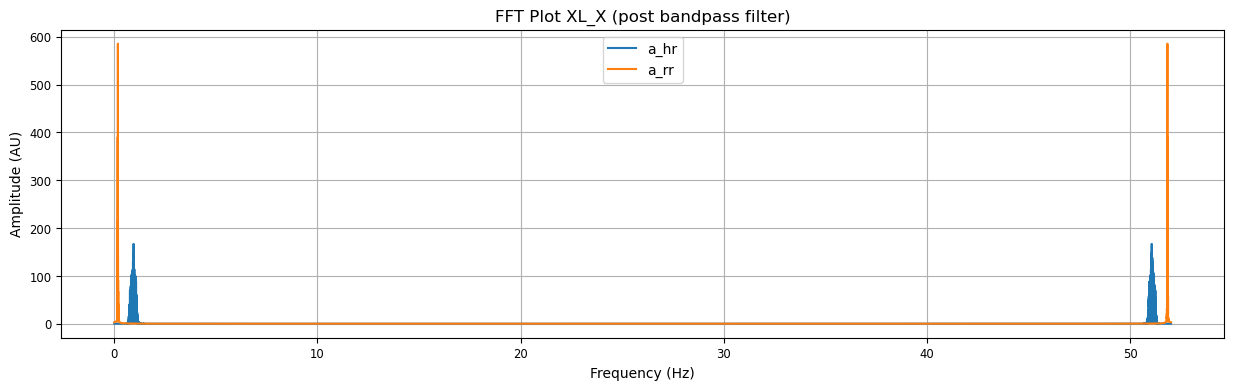

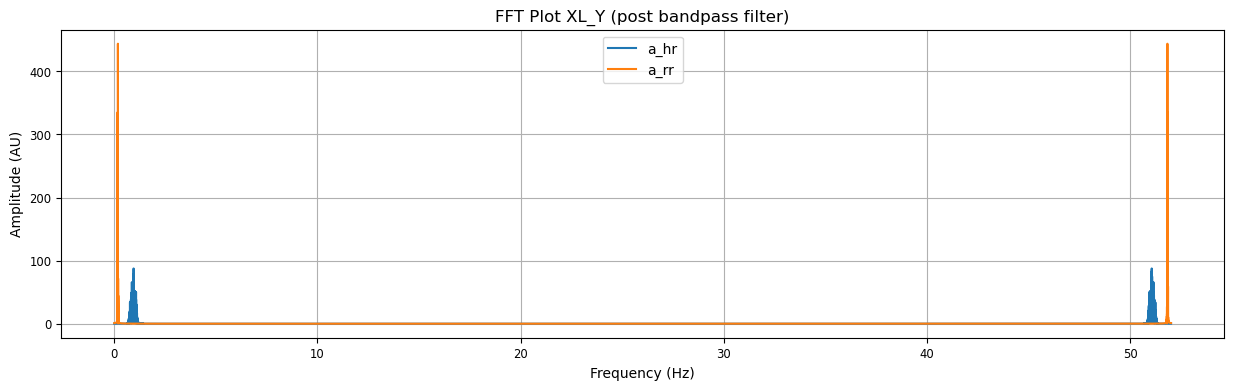

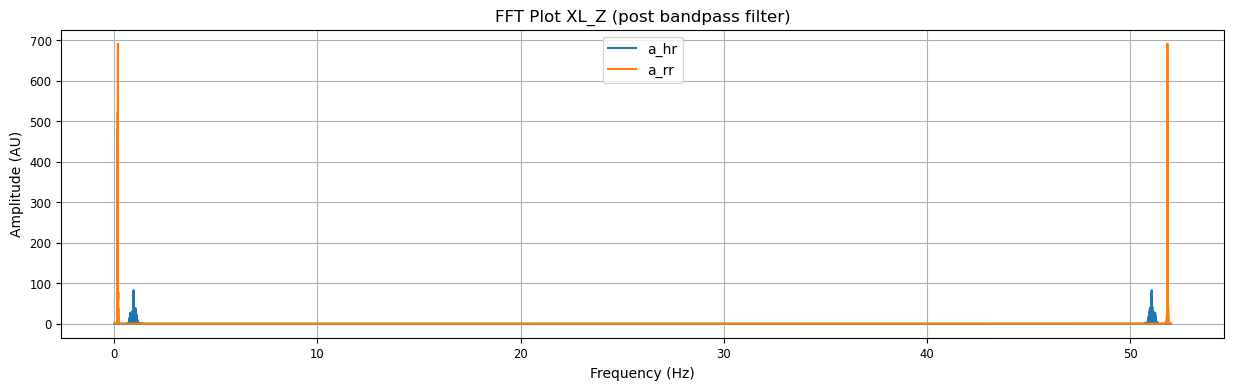

In [130]:
### Butterworth, non causal zero phase lag ###

for a_hr, a_rr, xl in zip(['x_hr', 'y_hr', 'z_hr'],['x_rr', 'y_rr', 'z_rr'], ['XL_X', 'XL_Y', 'XL_Z']):
    fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(15, 4))
    cropped_df[a_hr] = butter_bandpass_filter(cropped_df[xl], xl, lowcut_hr, highcut_hr, fs, order=4)
    cropped_df[a_rr] = butter_bandpass_filter(cropped_df[xl], xl, lowcut_rr, highcut_rr, fs, order=4)
    plt.legend(['a_hr', 'a_rr'])
    # plt.xlim(0, 52)

# cropped_df['x_rr'] = butter_bandpass_filter(cropped_df['XL_X'], 'XL_X_RR', lowcut_rr, highcut_rr, fs, order=4)
# cropped_df['y_rr'] = butter_bandpass_filter(cropped_df['XL_Y'], 'XL_Y_RR', lowcut_rr, highcut_rr, fs, order=4)
# cropped_df['z_rr'] = butter_bandpass_filter(cropped_df['XL_Z'], 'XL_Z_RR', lowcut_rr, highcut_rr, fs, order=4)

    #Why are they symmetric?
# cropped_df

In [131]:
# ### Plot after Butterworth RR"
# cropped_df.plot(x='Seconds', y=['x_rr', 'y_rr', 'z_rr'], figsize=(16, 6))
# plt.xlabel('Seconds (since start of experiment)', fontsize="15")
# plt.ylabel('Accelerometer Data (after Butterworth Filter) \n - Respiratory Rate frequencies', fontsize="15")
# # plt.xlim(1200, 1260) # Zoom in if you want

In [132]:
# ### Plot after Butterworth HR"
# cropped_df.plot(x='Seconds', y=['x_hr', 'y_hr', 'z_hr'], figsize=(16, 6))
# plt.xlabel('Seconds (since start of experiment)', fontsize="15")
# plt.ylabel('Accelerometer Data (after Butterworth Filter) \n - Heart Rate frequencies', fontsize="15")

In [133]:
cropped_df
cropped_df = cropped_df.set_index('Time', drop=False)
cropped_df.columns

Index(['Time', 'XL_X', 'XL_Y', 'XL_Z', 'G_X', 'G_Y', 'G_Z', 'Temperature',
       'Voltage', 'Packet', 'Seconds', 'x_hr', 'x_rr', 'y_hr', 'y_rr', 'z_hr',
       'z_rr'],
      dtype='object')

In [134]:
# # Counting zero crossings


# # From image about Pig Vitals under anesthesia
# # lowcut_hr = 1 # heart rate lower bound for bandpass filtering
# # highcut_hr = 2 # heart rate upper bound for bandpass filtering
# # lowcut_rr = 0.33 # respiratory rate lower bound for bandpass filtering
# # highcut_rr = 0.66 # respiratory rate upper bound for bandpass filtering


# zero_crossing_times_hr = []
# hr_pm = []
# for i, g in cropped_df.groupby(pd.Grouper(freq='1min', closed='right')):
#     if not g.empty:
#         f_x_hr, Pxx_den_x_hr = signal.welch(g['x_hr'], fs)
#         f_y_hr, Pxx_den_y_hr = signal.welch(g['y_hr'], fs)
#         f_z_hr, Pxx_den_z_hr = signal.welch(g['z_hr'], fs)
#         # get max value
#         d = {max(Pxx_den_x_hr):'x_hr', max(Pxx_den_y_hr): 'y_hr', max(Pxx_den_z_hr): 'z_hr'}
#         max_power = d.get()
#         # print(g[f'{max_power}'])
#         zero_crossings_hr = np.where(np.diff(np.sign(g[f'{max_power}'])))[0]
#         # generate the heart rate number per minute
#         # TODO: rewrite / doublecheck the function to output timestamp of which minute of the bpm
#         hr_pm.append([g.index[0], len(zero_crossings_hr)])
        
#         for x in zero_crossings_hr:
#             # print(g.iloc[x])
#             zero_crossing_times_hr.append(g.iloc[x])

# ## TODO: Check the groups and plot

# hr_pm = pd.DataFrame(hr_pm, columns=['Time', 'HR'])
# zc_dataset_hr = pd.DataFrame(zero_crossing_times_hr)
# zc_dataset_hr['intervals'] = (zc_dataset_hr['Time']-zc_dataset_hr['Time'].shift()).fillna(0)

# # for each 10 min window
# zero_crossing_times_rr = []
# rr_pm = []

# for i, g in cropped_df.groupby(pd.Grouper(freq='1min', closed='right')):
#     if not g.empty:
#         f_x_rr, Pxx_den_x_rr = signal.welch(g['x_rr'])
#         f_y_rr, Pxx_den_y_rr = signal.welch(g['y_rr'])
#         f_z_rr, Pxx_den_z_rr = signal.welch(g['z_rr'])
#         # print(g)
#         # get max value
#         d = {max(Pxx_den_x_rr):'x_rr', max(Pxx_den_y_rr): 'y_rr', max(Pxx_den_z_rr): 'z_rr'}
#         max_power_rr = d.get()
#         # print(g[f'{max_power}'])
#         zero_crossings_rr = np.where(np.diff(np.sign(g[f'{max_power_rr}'])))[0]
#         rr_pm.append([g.index[0], len(zero_crossings_rr)])
#         for x in zero_crossings_rr:
#             # print(g.iloc[x])
#             zero_crossing_times_rr.append(g.iloc[x])

        
# rr_pm = pd.DataFrame(rr_pm, columns=['Time', 'RR'])
# zc_dataset_rr = pd.DataFrame(zero_crossing_times_rr)
# zc_dataset_rr['intervals'] = (zc_dataset_rr['Time']-zc_dataset_rr['Time'].shift()).fillna(0)
# ## TODO: plot ugh


# # Add 'Seconds' column for plotting

# delta = hr_pm['Time'] - study_time
# hr_pm['Seconds'] = delta.dt.total_seconds()
# hr_pm['Seconds'] = pd.to_numeric(hr_pm['Seconds'], errors="coerce")

# delta = rr_pm['Time'] - study_time
# rr_pm['Seconds'] = delta.dt.total_seconds()
# rr_pm['Seconds'] = pd.to_numeric(rr_pm['Seconds'], errors="coerce")


# # hr_pm
# # rr_pm
# zero_crossing_times_hr
# df_zero_crossing_times_hr = pd.DataFrame(zero_crossing_times_hr,  columns=["Time", 'XL_X', 'XL_Y', 'XL_Z',
#     'G_X',  'G_Y',  'G_Z',
#     'Temperature', 'Voltage','Packet', 'Seconds', 'x_hr', 'y_hr', 'z_hr', 'x_rr', 'y_rr', 'z_rr'])

# df_zero_crossing_times_hr

In [135]:
# Zero crossings


zero_crossing_times_hr_2 = []
hr_pm_2 = []

for i, g in cropped_df.groupby(pd.Grouper(freq='1min', closed='right')):
    if not g.empty:
        f_x_hr, Pxx_den_x_hr = signal.welch(g['x_hr'])
        f_y_hr, Pxx_den_y_hr = signal.welch(g['y_hr'])
        f_z_hr, Pxx_den_z_hr = signal.welch(g['z_hr'])
        
        # get max value
        d = {max(Pxx_den_x_hr):'x_hr', max(Pxx_den_y_hr): 'y_hr', max(Pxx_den_z_hr): 'z_hr'}

        max_power_hr = d.get(max(d)) # str with name of column with highes PSD
        
        zero_crossings_hr = np.where(np.diff(np.sign(g[f'{max_power_hr}'])))[0] # list of indexes
        # print(zero_crossings_hr)

        
        estimates = [] #HR estimates for each interval between zero crossings
        for i,ix in enumerate(zero_crossings_hr[1:]):
            last_ix = zero_crossings_hr[i-1]
            delta = g.iloc[ix]['Seconds'] - g.iloc[last_ix]['Seconds']
            
            hr_this_interval = 1/delta
            # print(hr_this_interval)
            if lowcut_hr < hr_this_interval < highcut_hr:
                estimates.append(hr_this_interval*60)

        # print(estimates)
        estimates=np.array(estimates)
        std = np.std(estimates)
        avg = np.average(estimates)
        mask = np.abs(estimates - avg) <= std
        filtered = estimates[mask]
        this_median = np.median(filtered)
        
        # hr_pm_2.append(this_median)
        hr_pm_2.append([g['Seconds'].iloc[0], this_median])
        

df_hr_pm_2 = pd.DataFrame(hr_pm_2, columns = ['Seconds', 'HR'])

# ## TODO: Check the groups and plot

# hr_pm = pd.DataFrame(hr_pm, columns=['Time', 'HR'])
# zc_dataset_hr = pd.DataFrame(zero_crossing_times_hr)
# zc_dataset_hr['intervals'] = (zc_dataset_hr['Time']-zc_dataset_hr['Time'].shift()).fillna(0)

# for each 10 min window
zero_crossing_times_rr_2 = []
rr_pm_2 = []

for i, g in cropped_df.groupby(pd.Grouper(freq='1min', closed='right')):
    if not g.empty:
        f_x_rr, Pxx_den_x_rr = signal.welch(g['x_rr'])
        f_y_rr, Pxx_den_y_rr = signal.welch(g['y_rr'])
        f_z_rr, Pxx_den_z_rr = signal.welch(g['z_rr'])
        
        # get max value
        d = {max(Pxx_den_x_rr):'x_rr', max(Pxx_den_y_rr): 'y_rr', max(Pxx_den_z_rr): 'z_rr'}

        max_power_rr = d.get(max(d)) # str with name of column with highes PSD
        
        zero_crossings_rr = np.where(np.diff(np.sign(g[f'{max_power_rr}'])))[0] # list of indexes
        # print(zero_crossings_rr)

        
        estimates = [] #RR estimates for each interval between zero crossings
        for i,ix in enumerate(zero_crossings_rr[1:]):
            last_ix = zero_crossings_rr[i-1]
            delta = g.iloc[ix]['Seconds'] - g.iloc[last_ix]['Seconds']
            
            rr_this_interval = 1/delta
            # print(rr_this_interval)
            if lowcut_rr < rr_this_interval < highcut_rr:
                estimates.append(rr_this_interval*60)
        # print(estimates)
        estimates=np.array(estimates)
        std = np.std(estimates)
        avg = np.average(estimates)
        mask = np.abs(estimates - avg) <= std
        filtered = estimates[mask]
        this_median = np.median(filtered)
        
        rr_pm_2.append([g['Seconds'].iloc[0], this_median])

df_rr_pm_2 = pd.DataFrame(rr_pm_2, columns = ['Seconds', 'RR'])



In [136]:
# # Zero crossings again but now plotting the valid intervals


# # From image about Pig Vitals under anesthesia
# # lowcut_hr = 1 # heart rate lower bound for bandpass filtering
# # highcut_hr = 2 # heart rate upper bound for bandpass filtering
# # lowcut_rr = 0.33 # respiratory rate lower bound for bandpass filtering
# # highcut_rr = 0.66 # respiratory rate upper bound for bandpass filtering


# zero_crossing_times_hr_2 = []
# hr_pm_2 = []

# valid_intervals_hr = [] # List of tuples. Each tuple represents a valid interval
# valid_intervals_rr = [] # List of tuples. Each tuple represents a valid interval

# for i, g in cropped_df.groupby(pd.Grouper(freq='1min', closed='right')):
#     if not g.empty:
#         f_x_hr, Pxx_den_x_hr = signal.welch(g['x_hr'])
#         f_y_hr, Pxx_den_y_hr = signal.welch(g['y_hr'])
#         f_z_hr, Pxx_den_z_hr = signal.welch(g['z_hr'])
        
#         # get max value
#         d = {max(Pxx_den_x_hr):'x_hr', max(Pxx_den_y_hr): 'y_hr', max(Pxx_den_z_hr): 'z_hr'}

#         max_power_hr = d.get(max(d)) # str with name of column with highes PSD
        
#         zero_crossings_hr = np.where(np.diff(np.sign(g[f'{max_power_hr}'])))[0] # list of indexes
#         # print(f'zero crossings = {zero_crossings_hr}')
#         # for ix in zero_crossings_hr:
#         #     print(f'time intervals = {g.iloc[ix]['Seconds']}')

        
#         estimates = [] #HR estimates for each interval between zero crossings
#         for i,ix in enumerate(zero_crossings_hr):
#             if i>0:
#                 last_ix = zero_crossings_hr[i-1]
#                 delta = g.iloc[ix]['Seconds'] - g.iloc[last_ix]['Seconds']
                
#                 hr_this_interval = 1/delta
#                 # print(hr_this_interval)
#                 if lowcut_hr < hr_this_interval < highcut_hr:
#                     estimates.append(hr_this_interval*60)
#                     valid_intervals_hr.append((g.iloc[last_ix]['Seconds'], g.iloc[ix]['Seconds']))
#         # print(estimates)
#         this_median = np.median(estimates)
        
#         # hr_pm_2.append(this_median)
#         hr_pm_2.append([g['Seconds'].iloc[0], this_median])

# df_hr_pm_2 = pd.DataFrame(hr_pm_2, columns = ['Seconds', 'HR'])

# # ## TODO: Check the groups and plot

# # hr_pm = pd.DataFrame(hr_pm, columns=['Time', 'HR'])
# # zc_dataset_hr = pd.DataFrame(zero_crossing_times_hr)
# # zc_dataset_hr['intervals'] = (zc_dataset_hr['Time']-zc_dataset_hr['Time'].shift()).fillna(0)

# # for each 10 min window
# zero_crossing_times_rr_2 = []
# rr_pm_2 = []

# for i, g in cropped_df.groupby(pd.Grouper(freq='1min', closed='right')):
#     if not g.empty:
#         f_x_rr, Pxx_den_x_rr = signal.welch(g['x_rr'])
#         f_y_rr, Pxx_den_y_rr = signal.welch(g['y_rr'])
#         f_z_rr, Pxx_den_z_rr = signal.welch(g['z_rr'])
        
#         # get max value
#         d = {max(Pxx_den_x_rr):'x_rr', max(Pxx_den_y_rr): 'y_rr', max(Pxx_den_z_rr): 'z_rr'}

#         max_power_rr = d.get(max(d)) # str with name of column with highes PSD
        
#         zero_crossings_rr = np.where(np.diff(np.sign(g[f'{max_power_rr}'])))[0] # list of indexes
#         # print(zero_crossings_rr)

        
#         estimates = [] #RR estimates for each interval between zero crossings
#         for i,ix in enumerate(zero_crossings_rr):
#             if i>0:
#                 last_ix = zero_crossings_rr[i-1]
#                 delta = g.iloc[ix]['Seconds'] - g.iloc[last_ix]['Seconds']
                
#                 rr_this_interval = 1/delta
#                 # print(rr_this_interval)
#                 if lowcut_rr < rr_this_interval < highcut_rr:
#                     estimates.append(rr_this_interval*60)
#                     valid_intervals_rr.append((g.iloc[last_ix]['Seconds'], g.iloc[ix]['Seconds']))
#         # print(estimates)
#         this_median = np.median(estimates)
        
#         rr_pm_2.append([g['Seconds'].iloc[0], this_median])

# df_rr_pm_2 = pd.DataFrame(rr_pm_2, columns = ['Seconds', 'RR'])

In [137]:
# ax=cropped_df.plot(x='Seconds', y=['x_hr', 'y_hr', 'z_hr'], figsize = (15,3))
# for start, end in valid_intervals_hr:
#     # 1) Shade the interval
#     ax.axvspan(
#         start, end,
#         color='gray',
#         alpha=0.3,
#         zorder=0   # draw behind everything else
#     )
#     # 2) Draw X's on the x-axis
#     ax.scatter(
#         [start, end],            # x in data coords
#         [0, 0],                  # y=0 in axis fraction
#         marker='x',
#         s=100,
#         color='black',
#         linewidths=2,
#         transform=ax.get_xaxis_transform(),  
#         clip_on=False,
#         zorder=1   # draw on top of the shading
#     )

# ax.set_xlim(1600, 1660)
# ax.set_xlabel('Seconds')
# ax.set_ylabel('Heart‐Rate Signals')
# ax.set_title('HR Channels with Valid Intervals Highlighted')

# plt.tight_layout()
# plt.show()


In [138]:
def zero_crossing_intervals(g, zero_crossings, lowcut, highcut, output_estimates):
    """
    Performs the following steps:
    for a given interval g, and detected zero crossings, keeps the intervals
    with length dt such that lowcut<1/dt<highcut. For each valid interval it 
    creates an estimate 1/dt*60, and appends this estimate to output_estimates.
    
    """
    for i,ix in enumerate(zero_crossings):
        if i>0:
            last_ix = zero_crossings[i-1]
            delta = g.iloc[ix]['Seconds'] - g.iloc[last_ix]['Seconds']
            
            freq_this_interval = 1/delta
            if lowcut < freq_this_interval < highcut:
                output_estimates.append(freq_this_interval*60)



In [139]:
# # Zero crossings - first compute estimate for each interval and then find maximum power


# # From image about Pig Vitals under anesthesia
# # lowcut_hr = 1 # heart rate lower bound for bandpass filtering
# # highcut_hr = 2 # heart rate upper bound for bandpass filtering
# # lowcut_rr = 0.33 # respiratory rate lower bound for bandpass filtering
# # highcut_rr = 0.66 # respiratory rate upper bound for bandpass filtering


# hr_pm_3 = []
# rr_pm_3 = []

# for timestamp, g in cropped_df.groupby(pd.Grouper(freq='1min', closed='right')):

#     ## Heart Rate
#     zero_crossings_hr_x = np.where(np.diff(np.sign(g['x_hr'])))[0]
#     zero_crossings_hr_y = np.where(np.diff(np.sign(g['y_hr'])))[0]
#     zero_crossings_hr_z = np.where(np.diff(np.sign(g['z_hr'])))[0]

#     ### Resp Rate
#     zero_crossings_rr_x = np.where(np.diff(np.sign(g['x_rr'])))[0]
#     zero_crossings_rr_y = np.where(np.diff(np.sign(g['y_rr'])))[0]
#     zero_crossings_rr_z = np.where(np.diff(np.sign(g['z_rr'])))[0]

#     medians_hr = {}
#     medians_rr = {}
    
#     ############## X axis
#     estimates_x_hr = []
#     estimates_x_rr = []
    
#     zero_crossing_intervals(g, zero_crossings_hr_x, lowcut_hr, highcut_hr, estimates_x_hr)
#     zero_crossing_intervals(g, zero_crossings_rr_x, lowcut_rr, highcut_rr, estimates_x_rr)

#     if estimates_x_hr: # Only take if not empty
#         this_median_x_hr = np.median(estimates_x_hr)
#         medians_hr['x_hr'] = this_median_x_hr

#     if estimates_x_rr:
#         this_median_x_rr = np.median(estimates_x_rr)
#         medians_rr['x_rr'] = this_median_x_rr

    
#     ############ Y axis
#     estimates_y_hr = []
#     estimates_y_rr = []
    
#     zero_crossing_intervals(g, zero_crossings_hr_y, lowcut_hr, highcut_hr, estimates_y_hr)
#     zero_crossing_intervals(g, zero_crossings_rr_y, lowcut_rr, highcut_rr, estimates_y_rr)
    
#     if estimates_y_hr:
#         this_median_y_hr = np.median(estimates_y_hr)
#         medians_hr['y_hr'] = this_median_y_hr

#     if estimates_y_rr:
#         this_median_y_rr = np.median(estimates_y_rr)
#         medians_rr['y_rr'] = this_median_y_rr

    
#     ############### Z axis
#     estimates_z_hr = []
#     estimates_z_rr = []
    
#     zero_crossing_intervals(g, zero_crossings_hr_z, lowcut_hr, highcut_hr, estimates_z_hr)
#     zero_crossing_intervals(g, zero_crossings_rr_z, lowcut_rr, highcut_rr, estimates_z_rr)

#     if estimates_z_hr:
#         this_median_z_hr = np.median(estimates_z_hr)
#         medians_hr['z_hr'] = this_median_z_hr

#     if estimates_z_rr:
#         this_median_z_rr = np.median(estimates_z_rr)
#         medians_rr['z_rr'] = this_median_z_rr
        

#     ######### Choosing axis with largest power = mean absolute value
#     if not g.empty:
#         powers_hr = {
#             'x_hr': np.mean(np.abs(g['x_hr'])),
#             'y_hr': np.mean(np.abs(g['y_hr'])),
#             'z_hr': np.mean(np.abs(g['z_hr']))
#         }
#         max_axis_hr = sorted(powers_hr, key=powers_hr.get, reverse=True)

#         for axis in max_axis_hr:
#             # print(medians_hr.keys())
#             if axis in medians_hr:
#                 hr_pm_3.append([g['Seconds'].iloc[0], medians_hr[axis]])
#                 break
        
        
#         powers_rr = {
#             'x_rr': np.mean(np.abs(g['x_rr'])),
#             'y_rr': np.mean(np.abs(g['y_rr'])),
#             'z_rr': np.mean(np.abs(g['z_rr']))
#         }
        
#         max_axis_rr = sorted(powers_rr, key=powers_rr.get, reverse=True)

#         for axis in max_axis_rr:
#             if axis in medians_rr:
#                 rr_pm_3.append([g['Seconds'].iloc[0], medians_rr[axis]])
#                 break

#     # print(max_axis_rr)
# df_hr_pm_3 = pd.DataFrame(hr_pm_3, columns = ['Seconds', 'HR'])
# df_rr_pm_3 = pd.DataFrame(rr_pm_3, columns = ['Seconds', 'RR'])


In [140]:
# # Import ground data to compare:

# g_file = r"C:\Users\krisf\OneDrive\Desktop\UROP SU25\Ceara sleep detection\Modified Data\ground\ground_09192024.csv"
# g_data = pd.read_csv(g_file, header = header, dtype = str, delimiter = ',', names = ['Hour', 'Minute', 'Second','HR', 'RR'])
# g_df = pd.DataFrame(g_data, columns=['Hour', 'Minute', 'Second', "HR", "RR"])

# g_df["HR"] = pd.to_numeric(g_df["HR"], errors="coerce")
# g_df["RR"] = pd.to_numeric(g_df["RR"], errors="coerce")

# times = g_df[['Hour','Minute','Second']].astype(str).agg(':'.join, axis=1)

# g_df['Time'] = pd.to_datetime('09192024'+' '+times+'.000', format='%m%d%Y %H:%M:%S.%f')

# g_df = g_df.drop(['Hour','Minute','Second'], axis=1)

# delta = g_df['Time'] - study_time
# g_df['Seconds'] = delta.dt.total_seconds()
# g_df['Seconds'] = pd.to_numeric(g_df['Seconds'], errors="coerce")
# g_df


# fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))
# ax1.plot(g_df['Seconds'], g_df['HR'], label='Ground HR')
# ax1.plot(df_hr_pm_2['Seconds'], df_hr_pm_2['HR'], label='Predicted HR')
# ax1.set_xlabel('Seconds (s) from start')
# ax1.set_ylabel('Heart Rate')
# ax1.set_title('Overlapped HR from Two Files')
# ax1.legend()



# ax2.plot(g_df['Seconds'], g_df['RR'], label='Ground RR')
# ax2.plot(df_rr_pm_2['Seconds'], df_rr_pm_2['RR'], label='Predicted RR')
# ax2.set_xlabel('Seconds (s) from start')
# ax2.set_ylabel('Respiratory Rate')
# ax2.set_title('Overlapped RR from Two Files')
# ax2.legend()

C:\Users\krisf\AppData\Local\Temp\ipykernel_33016\175526003.py:4: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  g_data = pd.read_csv(g_file, header = header, index_col=False, dtype = 'Int64', delimiter = ',', names = ['Hour', 'Minute', 'Second','HR', 'RR'])


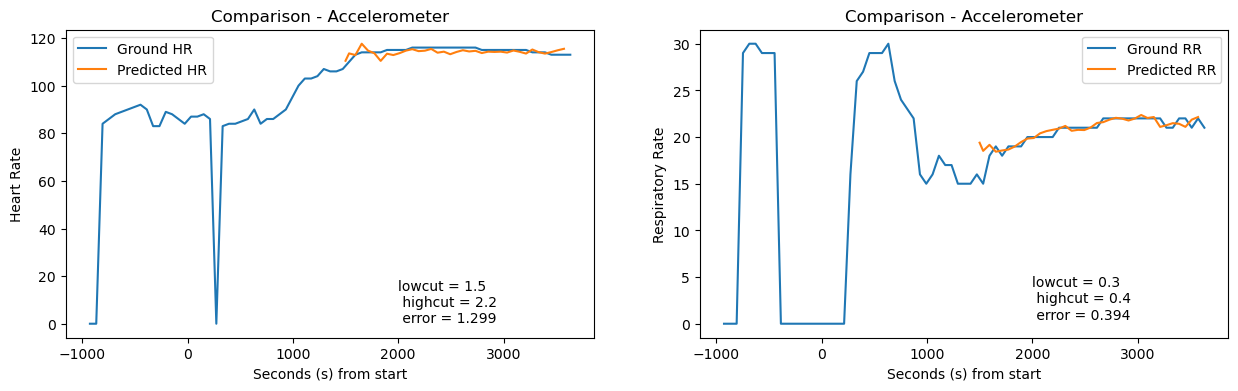

In [141]:
# Import ground data to compare:
g_file = r"C:\Users\krisf\OneDrive\Desktop\UROP SU25\Ceara sleep detection\Modified Data\ground\ground_07022025.csv"
header=0
g_data = pd.read_csv(g_file, header = header, index_col=False, dtype = 'Int64', delimiter = ',', names = ['Hour', 'Minute', 'Second','HR', 'RR'])
g_df = pd.DataFrame(g_data, columns=['Hour', 'Minute', 'Second', "HR", "RR"])

g_df["HR"] = pd.to_numeric(g_df["HR"], errors="coerce")
g_df["RR"] = pd.to_numeric(g_df["RR"], errors="coerce")

times = g_df[['Hour','Minute','Second']].astype(str).agg(':'.join, axis=1)

g_df['Time'] = pd.to_datetime('07022025'+' '+times+'.000', format='%m%d%Y %H:%M:%S.%f')

g_df = g_df.drop(['Hour','Minute','Second'], axis=1)

delta = g_df['Time'] - study_time
g_df['Seconds'] = delta.dt.total_seconds()
g_df['Seconds'] = pd.to_numeric(g_df['Seconds'], errors="coerce")


g_df_interval = g_df[g_df['Seconds']>1500]
abs_errors_hr = abs(g_df_interval['HR'].values-df_hr_pm_2['HR'].values)
mean_error_hr = np.mean(abs_errors_hr)


g_df_interval = g_df[g_df['Seconds'] > 1500]
abs_errors_rr = np.abs(g_df_interval['RR'].values - df_rr_pm_2['RR'].values)
mean_error_rr = np.mean(abs_errors_rr)

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))
ax1.plot(g_df['Seconds'], g_df['HR'], label='Ground HR')
ax1.plot(df_hr_pm_2['Seconds'], df_hr_pm_2['HR'], label='Predicted HR')
ax1.set_xlabel('Seconds (s) from start')
ax1.set_ylabel('Heart Rate')
ax1.set_title('Comparison - Accelerometer')
ax1.text(2000,0.5,f'lowcut = {lowcut_hr} \n highcut = {highcut_hr} \n error = {round(mean_error_hr,3)}')
ax1.legend()



ax2.plot(g_df['Seconds'], g_df['RR'], label='Ground RR')
ax2.plot(df_rr_pm_2['Seconds'], df_rr_pm_2['RR'], label='Predicted RR')
ax2.set_xlabel('Seconds (s) from start')
ax2.set_ylabel('Respiratory Rate')
ax2.set_title('Comparison - Accelerometer')
ax2.text(2000,0.5,f'lowcut = {lowcut_rr} \n highcut = {highcut_rr} \n error = {round(mean_error_rr,3)}')
ax2.legend()

In [142]:
mean_error_hr

1.2993111155800168